In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import scipy.misc

plt.style.use('ggplot')

%matplotlib inline

# Визуализация

Есть несколько способов понять что же на самом деле выучила сеть:

* Визуализация фильтров
* Карты активации
* Нахождение изображений максимизирующих класс
* Генерация изображений максимизирующих активацию нейрона

In [52]:
import keras
import keras.applications
import tensorflow as tf
import keras.backend as K

session = tf.InteractiveSession()
model = keras.applications.VGG16(include_top=True, weights='imagenet')

Фильтры первого слоя сети


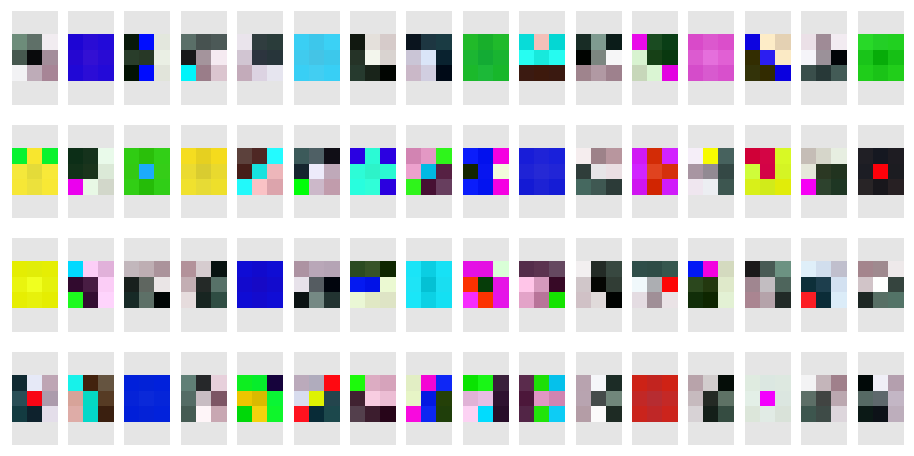

In [4]:
import keras
import keras.applications
import tensorflow as tf

first_conv_layer = model.layers[1]
kernels = first_conv_layer.weights[0]
w = kernels.value().eval(session=session)

fig, axes = plt.subplots(4, 16, sharex=True, sharey=True, figsize=(16, 8))

print('Фильтры первого слоя сети')

for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        kernel_index = i * 16 + j
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.imshow(w[:, :, :, kernel_index])

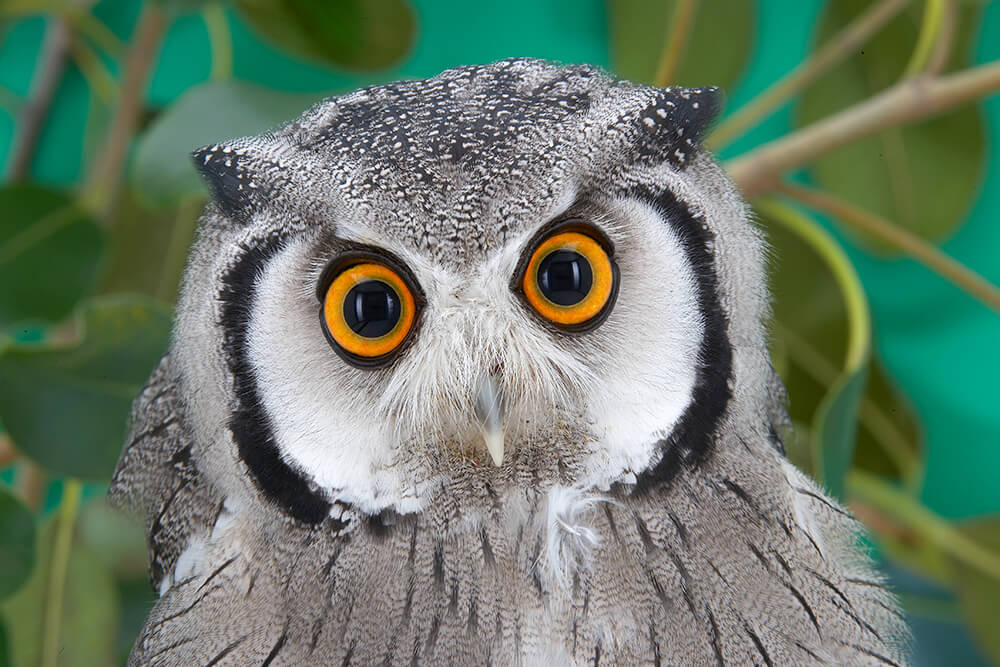

In [17]:
import urllib.request
from PIL import Image

url = 'http://animals.sandiegozoo.org/sites/default/files/2016-10/owl_southern_white_faced.jpg'
response = urllib.request.urlopen(url)
image = Image.open(response)
image

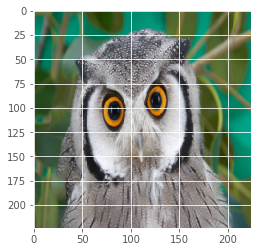

In [32]:
def preprocess_image(image):
    arr = np.asarray(image)
    arr = scipy.misc.imresize(arr, (224, 224))
    return np.expand_dims(arr, 0)

model_input = preprocess_image(image)
plt.imshow(model_input[0])

In [44]:
from keras.applications.vgg16 import decode_predictions

predicted_classes = model.predict(model_input)
decode_predictions(predicted_classes, top=3)

[[('n01622779', 'great_grey_owl', 0.98155826),
  ('n02497673', 'Madagascar_cat', 0.0039107339),
  ('n02808304', 'bath_towel', 0.0012786832)]]

In [130]:
def build_activation_maps_model(model, target_layer):

    last_conv_layer = model.get_layer(target_layer)   
    activation_maps = keras.layers.Lambda(lambda x: tf.image.resize_images(x, (224, 224)))(last_conv_layer.output)
    
    return keras.models.Model(model.input, activation_maps)

In [136]:
am_model = build_activation_maps_model(model, 'block5_conv3')
activation_maps = am_model.predict(model_input)
activation_maps.shape

(1, 224, 224, 512)

In [139]:
activation_heatmap = np.sum(np.squeeze(activation_maps), axis=2)
activation_heatmap.shape

(224, 224)

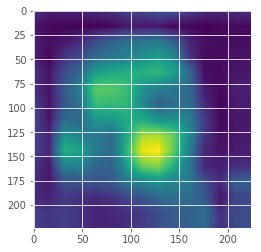

In [140]:
plt.imshow(activation_heatmap)